In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
import pandas as pd
from tqdm import tqdm
import os
import json
import yaml
import time
import numpy as np
import matplotlib.pyplot as plt
import copy
from collections import defaultdict
#my imports
from models.CNN import CNN
from models.ResNet import ResNet18, create_model
from utils.connectivity import linear_interpolated_model, evaluate_loss
from utils.utils import get_data_loaders
from find_permutation import res_permute

In [ ]:

data_config = {
  "augment_test": False,
  "batch_size": 256,
  "data_augmentation": "hflip",
  "data_root": "./data/",
  "dataset": "CIFAR10",
  }
train_data_loader, _ = get_data_loaders(data_config)


Files already downloaded and verified
Files already downloaded and verified


# Sharp Minima

In [ ]:
#os.environ["CUDA_VISIBLE_DEVICES"] = "2"

def evaluate_flatness(model, criterion, data_loader, epsilon=1e-3, num_samples=25, device="cpu"):
  model.eval()
  model.to(device)

  x,y = next(iter(data_loader))
  x,y = x.to(device),y.to(device)
  with torch.no_grad():
    out = model(x)
    base_loss = criterion(out,y)
    max_loss = base_loss
    for _ in range(num_samples):
      new_model = copy.deepcopy(model)
      for param in new_model.parameters():
        if param.requires_grad:
          perturabtion = epsilon * torch.randn_like(param.data) # * (param.data.abs() + 1e-6)
          param.data.add_(perturabtion)
      new_model.to(device)
      out = new_model(x)
      loss = criterion(out,y)
      if loss > max_loss:
        max_loss = loss
      del new_model
    torch.cuda.empty_cache()
  increase = max_loss-base_loss 
  sharpness = increase # / (1.0+base_loss)
  return sharpness, base_loss, max_loss

data_config = {
  "augment_test": False,
  "batch_size": 256,
  "data_augmentation": "vanilla",
  "data_root": "./data/",
  "dataset": "CIFAR10",
  }
train_data_loader, _ = get_data_loaders(data_config)

model_paths = [
    "logs/vanilla/vanilla_1/final_model.pt",
    "logs/vanilla/hflip_1/final_model.pt",
    "logs/vanilla/vflip_1/final_model.pt",
    "logs/vanilla/hvflip_1/final_model.pt",
    "logs/vanilla/rot90_1/final_model.pt",
    ]
epsilons = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
results = {key: defaultdict(list) for key in model_paths}
for epsilon in epsilons:
  print(f"Evaluating for eps: {epsilon}")
  for model_path in model_paths:
    print(f"Evaluating model: {model_path}")
    model = ResNet18()
    model.load_state_dict(torch.load(model_path))
    model.eval()

    criterion = nn.CrossEntropyLoss()

    device = "cuda:3" if torch.cuda.is_available() else "cpu"

    sharpness, base_loss, max_loss = evaluate_flatness(model, criterion, train_data_loader, epsilon=epsilon, num_samples=25, device=device)
    results[model_path]["sharpness"] += [sharpness]
    results[model_path]["base_loss"]  += [base_loss]
    results[model_path]["max_loss"] += [max_loss]
    del model
    torch.cuda.empty_cache()
        

no data augmentation applied
Files already downloaded and verified
Files already downloaded and verified
Evaluating for eps: 1e-06
Evaluating model: logs/vanilla/vanilla_1/final_model.pt


/tmp/ipykernel_36735/374783189.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Evaluating model: logs/vanilla/hflip_1/final_model.pt
Evaluating model: logs/vanilla/vflip_1/final_model.pt
Evaluating model: logs/vanilla/hvflip_1/final_model.pt
Evaluating model: logs/vanilla/rot90_1/final_model.pt
Evaluating for eps: 1e-05
Evaluating model: logs/vanilla/vanilla_1/final_model.pt
Evaluating model: logs/vanilla/hflip_1/final_model.pt
Evaluating model: logs/vanilla/vflip_1/final_model.pt
Evaluating model: logs/vanilla/hvflip_1/final_model.pt
Evaluating model: logs/vanilla/rot90_1/final_model.pt
Evaluating for eps: 0.0001
Evaluating model: logs/vanilla/vanilla_1/final_model.pt
Evaluating model: logs/vanilla/hflip_1/final_model.pt
Evaluating model: logs/vanilla/vflip_1/final_model.pt
Evaluating model: logs/vanilla/hvflip_1/final_model.pt
Evaluating model: logs/vanilla/rot90_1/final_model.pt
Evaluating for eps: 0.001
Evaluating model: logs/vanilla/vanilla_1/final_model.pt
Evaluating model: logs/vanilla/hflip_1/final_model.pt
Evaluating model: logs/vanilla/vflip_1/final_mod

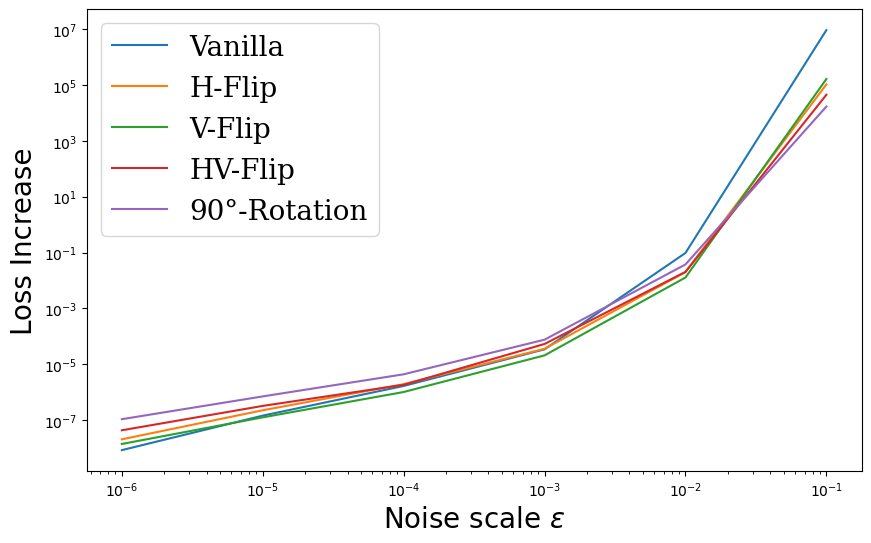

In [ ]:

plt.figure(figsize=(10,6))
model_mapping = {
    "logs/vanilla/vanilla_1/final_model.pt" : "Vanilla",
    "logs/vanilla/hflip_1/final_model.pt" : "H-Flip",
    "logs/vanilla/vflip_1/final_model.pt": "V-Flip",
    "logs/vanilla/hvflip_1/final_model.pt": "HV-Flip",
    "logs/vanilla/rot90_1/final_model.pt": "90°-Rotation",
}
for key, label in model_mapping.items():
  data = results[key]["sharpness"]
  data = [value.item() for value in data]
  plt.plot(epsilons, data, label=label)

plt.rcParams.update({
    "font.family": "serif",
    "axes.labelsize": 22,
    "font.size": 20,
    "legend.fontsize": 20,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
})
plt.legend()
ax = plt.gca()
ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
ax.set_xlabel(r'Noise scale $\epsilon$', fontsize=20)

ax.set_ylabel("Loss Increase", fontsize=20)
plt.xscale("log")
plt.yscale("log")

plt.show()

# Start to End Interpolation

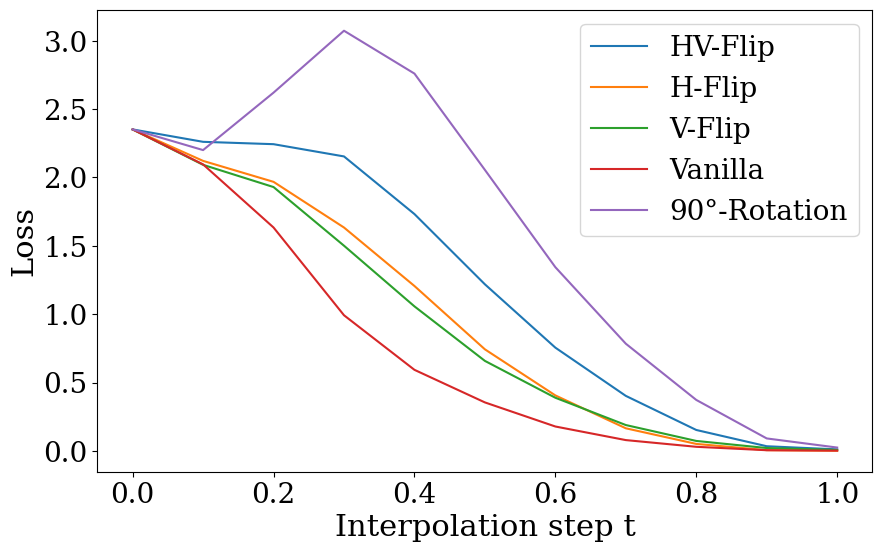

In [ ]:
path = "logs/convexity_connectivity"
files = ["hvflip_to_start","hflip_to_start","vflip_to_start", "vanilla_to_start", "rot90_to_start"]
file_to_label= {"hvflip_to_start" : "HV-Flip","hflip_to_start": "H-Flip","vflip_to_start": "V-Flip", "vanilla_to_start":"Vanilla", "rot90_to_start":"90°-Rotation"}

plt.figure(figsize=(10,6))
x = [0.1 * i for i in range(11)]
for file in files:
    joint_path = os.path.join(path, file)
    with open(joint_path, "r") as f:
        config = json.load(f)
    losses =list(reversed(config["losses"]))
    #accs = config["accs"]
    plt.plot(x, losses, label= file_to_label[file])
    #plt.plot(accs, label=file)
plt.legend()

plt.rcParams.update({
    "font.family": "serif",
    "axes.labelsize": 22,
    "font.size": 20,
    "legend.fontsize": 20,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
})
plt.xlabel("Interpolation step t")
plt.ylabel("Loss")
plt.show()

# Augmented vs Vanilla Connectivity

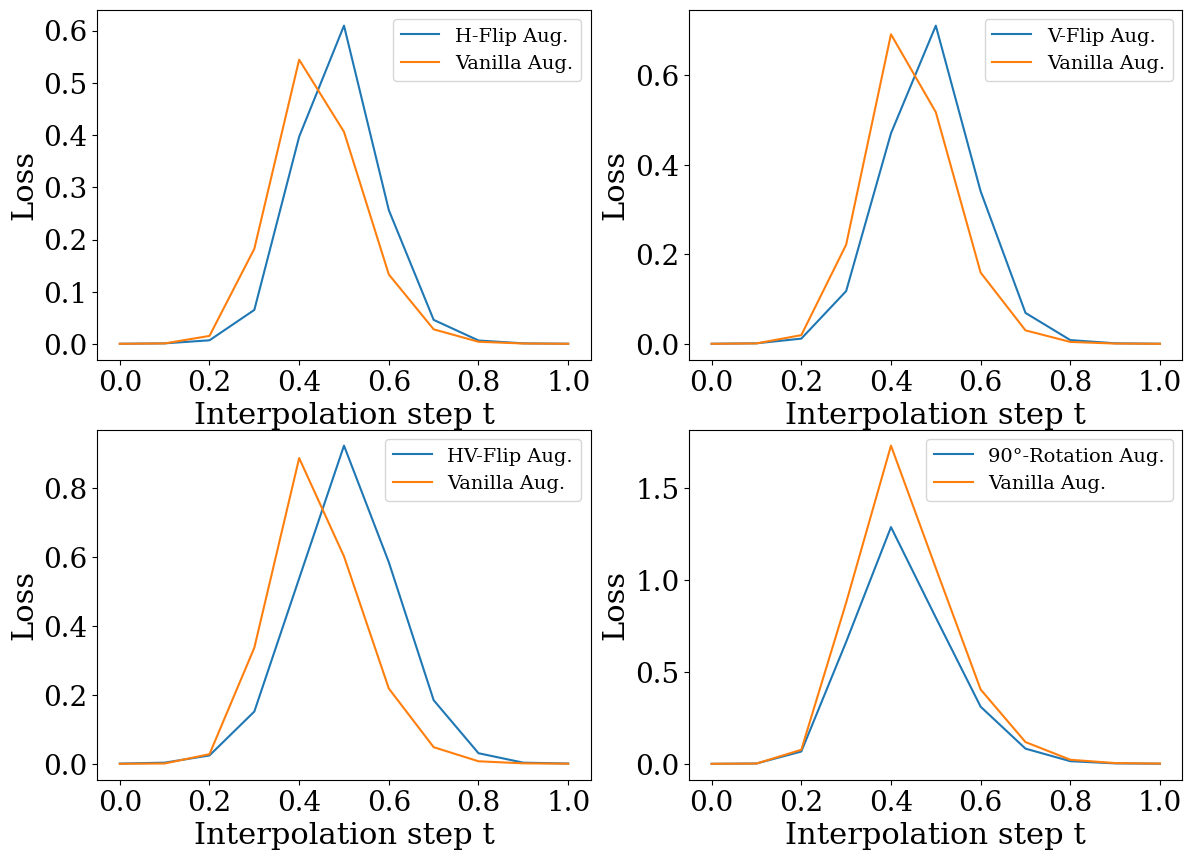

In [ ]:
path_pairs = [("logs/connectivity_augmented/hflip_aug_to_hflip_symmetry_lmcp", "logs/vanilla_connectivity/vanilla_1_to_hflip_1_lmcp"),
              ("logs/connectivity_augmented/vflip_aug_to_vflip_symmetry_lmcp", "logs/vanilla_connectivity/vanilla_1_to_vflip_1_lmcp"),
              ("logs/connectivity_augmented/hvflip_aug_to_hvflip_symmetry_lmcp", "logs/vanilla_connectivity/vanilla_1_to_hvflip_1_lmcp"),
              ("logs/connectivity_augmented/rot90_aug_to_rot90_symmetry_lmcp", "logs/vanilla_connectivity/vanilla_1_to_rot90_1_lmcp")]
labels = [("H-Flip Aug.", "Vanilla Aug."),
          ("V-Flip Aug.", "Vanilla Aug."),
          ("HV-Flip Aug.", "Vanilla Aug."),
          ("90°-Rotation Aug.", "Vanilla Aug.")]

fig, axs = plt.subplots(2,2, figsize=(14,10))
axs = axs.flatten()

plt.rcParams.update({
        "font.family": "serif",
        "axes.labelsize": 18,
        "font.size": 16,
        "legend.fontsize": 14,
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
    })
for i,(path_1, path_2) in enumerate(path_pairs):
    label_1, label_2 = labels[i]
    ax = axs[i]
    x = [0.1 * i for i in range(11)]
    with open(path_1, "r") as f:
        config = json.load(f)
    losses_1 =list(reversed(config["losses"]))
    with open(path_2, "r") as f:
        config = json.load(f)
    losses_2 =list(reversed(config["losses"]))
    #accs = config["accs"]
    ax.plot(x, losses_1, label=label_1 )
    ax.plot(x, losses_2, label=label_2)
    #plt.plot(accs, label=file)


    ax.legend()
    ax.set_xlabel("Interpolation step t")
    ax.set_ylabel("Loss")
    #ax.set_title(f"{label_1} vs {label_2}")

plt.show()


# Main Results - Linear Connectivity

[[1.24146536 1.46477219 2.1413042  1.24420906 1.52513145]
 [       nan 2.08411974 1.70119995 1.97872927 1.89483997]
 [       nan        nan 1.46385829 2.16314866 1.88371546]
 [       nan        nan        nan 2.16814838 2.10206912]
 [       nan        nan        nan        nan 2.98705162]]
[[0.45369329 0.54448278 0.69149196 0.88650388 1.73323137]
 [       nan 0.6687468  0.88720998 0.81811582 1.15664456]
 [       nan        nan 0.72973963 0.71746998 1.19214348]
 [       nan        nan        nan 0.60355353 1.28243374]
 [       nan        nan        nan        nan 1.51471332]]


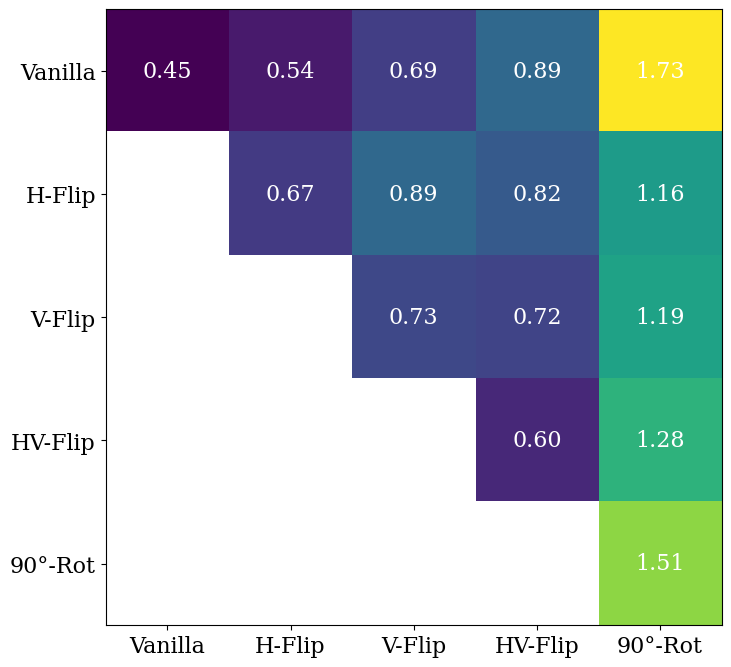

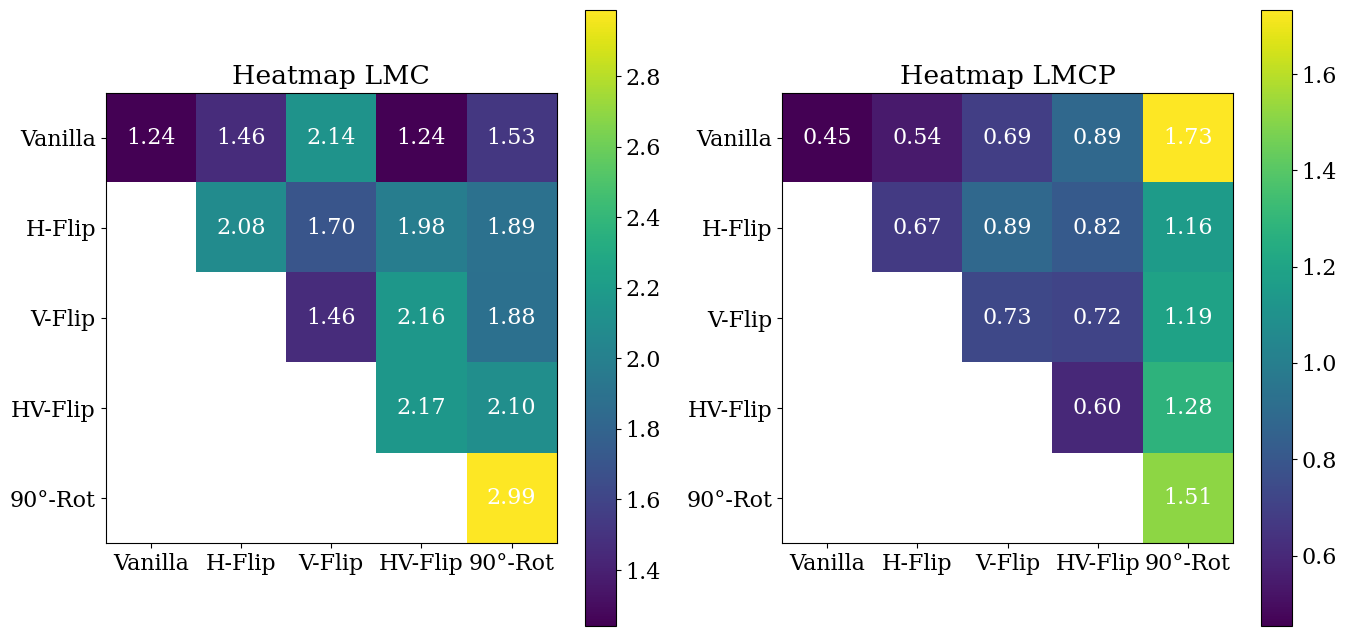

In [ ]:
#From: https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html
files_to_evaluate_lmc = {
    "vanilla": [
    "./logs/vanilla_connectivity/vanilla_1_to_hflip_1_lmc",
    "./logs/vanilla_connectivity/vanilla_1_to_hvflip_1_lmc",
    "./logs/vanilla_connectivity/vanilla_1_to_rot90_1_lmc",
    "./logs/vanilla_connectivity/vanilla_1_to_vflip_1_lmc",
    "./logs/vanilla_connectivity/vanilla_1_to_vanilla_2_lmc",
    ],
    "hflip":
    [
    "./logs/vanilla_connectivity/hflip_1_to_rot90_1_lmc",
    "./logs/vanilla_connectivity/hflip_1_to_vflip_1_lmc",
    "./logs/vanilla_connectivity/hflip_1_to_hvflip_1_lmc",
    "./logs/vanilla_connectivity/hflip_1_to_hflip_2_lmc",
    ],
    "vflip":
    [
    "./logs/vanilla_connectivity/vflip_1_to_hvflip_1_lmc",
    "./logs/vanilla_connectivity/vflip_1_to_rot90_1_lmc",
    "./logs/vanilla_connectivity/vflip_1_to_vflip_2_lmc",
    ],
    "hvflip":
    [
    "./logs/vanilla_connectivity/hvflip_1_to_hvflip_2_lmc",
    "./logs/vanilla_connectivity/hvflip_1_to_rot90_1_lmc",
    ],
    "rot90":
    [
    "./logs/vanilla_connectivity/rot90_1_to_rot90_2_lmc",
    ],
}
files_to_evaluate_lmcp = {
    "vanilla": [
    "./logs/vanilla_connectivity/vanilla_1_to_vanilla_2_lmcp",
    "./logs/vanilla_connectivity/vanilla_1_to_hflip_1_lmcp",
    "./logs/vanilla_connectivity/vanilla_1_to_vflip_1_lmcp",
    "./logs/vanilla_connectivity/vanilla_1_to_hvflip_1_lmcp",
    "./logs/vanilla_connectivity/vanilla_1_to_rot90_1_lmcp",
    ],
    "hflip":
    [
    "./logs/vanilla_connectivity/hflip_1_to_hflip_2_lmcp",
    "./logs/vanilla_connectivity/hflip_1_to_vflip_1_lmcp",
    "./logs/vanilla_connectivity/hflip_1_to_hvflip_1_lmcp",
    "./logs/vanilla_connectivity/hflip_1_to_rot90_1_lmcp",
    ],
    "vflip":
    [
    "./logs/vanilla_connectivity/vflip_1_to_vflip_2_lmcp",
    "./logs/vanilla_connectivity/vflip_1_to_hvflip_1_lmcp",
    "./logs/vanilla_connectivity/vflip_1_to_rot90_1_lmcp",
    ],
    "hvflip":
    [
    "./logs/vanilla_connectivity/hvflip_1_to_hvflip_2_lmcp",
    "./logs/vanilla_connectivity/hvflip_1_to_rot90_1_lmcp",
    ],
    "rot90":
    [
    "./logs/vanilla_connectivity/rot90_1_to_rot90_2_lmcp",
    ],
}
symmetries_to_label = {"vanilla": "Vanilla", "hflip": "H-Flip", "vflip": "V-Flip","hvflip": "HV-Flip","rot90": "90°-Rot"}
symmetries = ["vanilla", "hflip", "vflip","hvflip","rot90"]
heatmap_lmc = { symmetry : [] for symmetry in symmetries}
for symmetry,file_list in files_to_evaluate_lmc.items():
    for file in file_list:
        with open(file, "r") as f:
            data = json.load(f)
        heatmap_lmc[symmetry] += [max(data["losses"])]
heatmap_lmcp = { symmetry : [] for symmetry in symmetries}
for symmetry,file_list in files_to_evaluate_lmcp.items():
    for file in file_list:
        with open(file, "r") as f:
            data = json.load(f)
        heatmap_lmcp[symmetry] += [max(data["losses"])]

array_heatmap_lmc = np.array([[np.nan] * 5] * 5)
array_heatmap_lmcp = np.array([[np.nan] * 5] * 5)

for j, values in enumerate(heatmap_lmc.values()):
    rev_values = list(reversed(values))
    for i in range(len(values)):
        array_heatmap_lmc[j][4-i] = rev_values[i]
print(array_heatmap_lmc)


for j, values in enumerate(heatmap_lmcp.values()):
    rev_values = list(reversed(values))
    for i in range(len(values)):
        array_heatmap_lmcp[j][4-i] = rev_values[i]
print(array_heatmap_lmcp)

plt.figure(figsize=(8, 8))
plt.imshow(array_heatmap_lmcp, cmap="viridis")

plt.xticks(np.arange(5), list(symmetries_to_label.values()))
plt.yticks(np.arange(5), list(symmetries_to_label.values()))
for i in range(5):
    for j in range(5):
        text = plt.text(j, i, f"{array_heatmap_lmcp[i, j]:.2f}",
                       ha="center", va="center", color="w")


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,8))

im1 = ax1.imshow(array_heatmap_lmc, cmap = "viridis")
ax1.set_title("Heatmap LMC")
ax1.set_yticks(np.arange(5))
ax1.set_yticklabels(symmetries_to_label.values())
ax1.set_xticks(np.arange(5))
ax1.set_xticklabels(symmetries_to_label.values())
fig.colorbar(im1, ax=ax1)

for i in range(5):
    for j in range(5):
        text = ax1.text(j, i, f"{array_heatmap_lmc[i, j]:.2f}",
                       ha="center", va="center", color="w")

im2 = ax2.imshow(array_heatmap_lmcp, cmap = "viridis")
ax2.set_title("Heatmap LMCP")
ax2.set_yticks(np.arange(5))
ax2.set_yticklabels(symmetries_to_label.values())
ax2.set_xticks(np.arange(5))
ax2.set_xticklabels(symmetries_to_label.values())
fig.colorbar(im2, ax=ax2)
for i in range(5):
    for j in range(5):
        text = ax2.text(j, i, f"{array_heatmap_lmcp[i, j]:.2f}",
                       ha="center", va="center", color="w")
plt.show()

# Symmetry over time

### Import CSV file from Weights and Biases

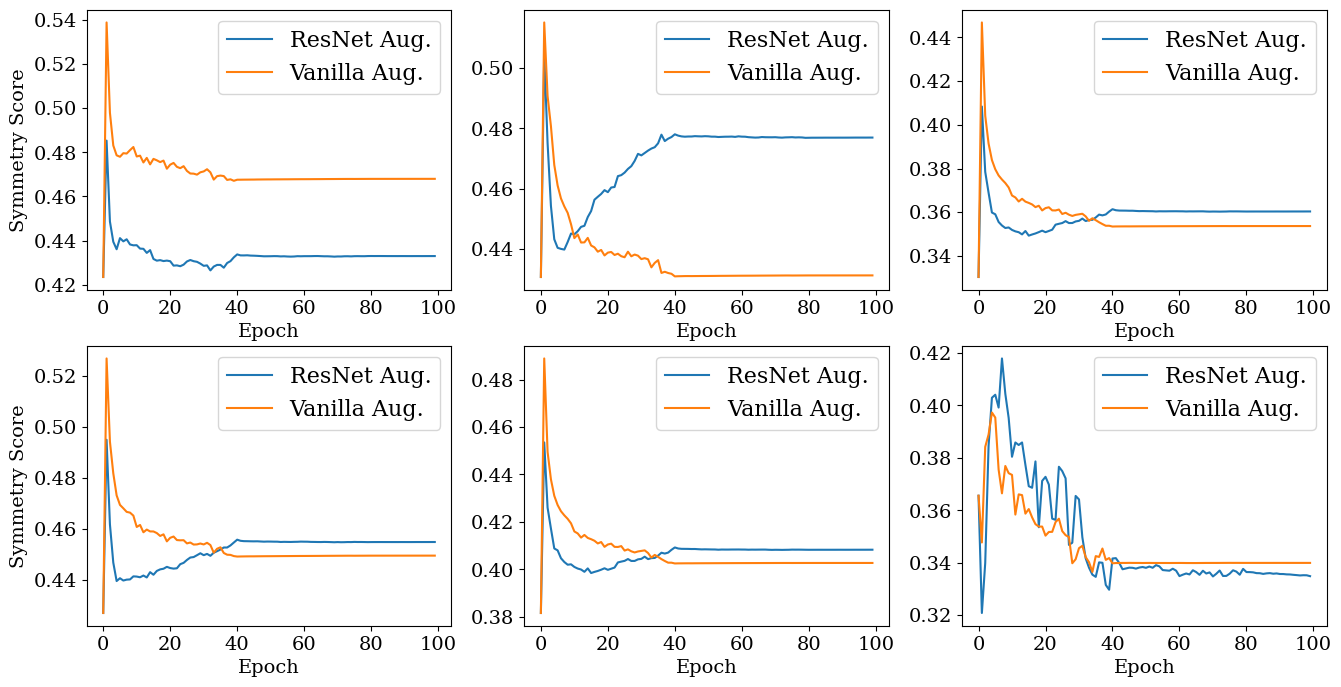

In [ ]:

plt.rcParams.update({
        "font.family": "serif",
        "axes.labelsize": 14,
        "font.size": 14,
        "legend.fontsize": 16,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
    })
data_paths = {
    "hflip": "logs/symmetry_tracking/horizontal_symmetry.csv",
    "vflip": "logs/symmetry_tracking/vertical_symmetry.csv",
    "rot90": "logs/symmetry_tracking/rot90_symmetry.csv",
    "hvflip": "logs/symmetry_tracking/hv_symmetry.csv",
    "total_symmetry": "logs/symmetry_tracking/total_symmetry.csv",
    "total_mean_symmetry": "logs/symmetry_tracking/total_mean_symmetry.csv"
}
fig, axs = plt.subplots(2,3, figsize=(16,8))
axs = axs.flatten()
for i,(key, path) in enumerate(data_paths.items()):
    df = pd.read_csv(path, header=None, skiprows=1)
    #print(df.head())
    ax = axs[i]
    ax.plot(df[1], label="ResNet Aug.")
    ax.plot(df[4], label="Vanilla Aug.")
    ax.legend()
    if i % 3 == 0:
        ax.set_ylabel("Symmetry Score")
    ax.set_xlabel("Epoch")
    